Looking at Autoantibody results from ImmPort Studies
* SDY1737
* SDY1625 ?
* SDY524
* SDY569
* SDY655 ?
* SDY797 ?
* SDY824
* SDY91

Look at K-Means 
Unsupervised clustering

In [1]:
if (!require("devtools", quietly = TRUE))
    install.packages("devtools", repos = "https://cloud.r-project.org")

In [2]:
if (!require("shiny", quietly = TRUE))
    install.packages("shiny", repos = "https://cloud.r-project.org")


In [3]:
if (!require("tidyHeatmap", quietly = TRUE))
    install.packages("tidyHeatmap", repos = "https://cloud.r-project.org")


tidyHeatmap version 1.12.1
If you use tidyHeatmap in published research, please cite:
1) Mangiola et al. tidyHeatmap: an R package for modular heatmap production 
  based on tidy principles. JOSS 2020.
2) Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.
This message can be suppressed by:
  suppressPackageStartupMessages(library(tidyHeatmap))



Attaching package: ‘tidyHeatmap’


The following object is masked from ‘package:stats’:

    heatmap




In [4]:
if (!require("stemangiola/tidyHeatmap", quietly = TRUE))
    devtools::install_github("stemangiola/tidyHeatmap")


Using GitHub PAT from the git credential store.

Skipping install of 'tidyHeatmap' from a github remote, the SHA1 (27b34a64) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", repos = "https://cloud.r-project.org")



Attaching package: ‘BiocManager’


The following object is masked from ‘package:devtools’:

    install




In [6]:
BiocManager::install("dplyr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'dplyr'”
Old packages: 'patchwork', 'tidyHeatmap', 'broom', 'curl', 'later', 'pbkrtest',
  'xfun', 'xml2'



In [7]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
options(repos = c(CRAN = "https://cloud.r-project.org"))
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!requireNamespace("tibble", quietly = TRUE)) install.packages("tibble")

library(dplyr)
library(tidyr)
library(tibble)

packageVersion("tidyr")  # should be >= "1.0.0"


[1] ‘1.3.1’

**Function:** *make_aa_heatmaps* 

**Purpose** 

*make_aa_heatmaps* will make as requested a k-means heatmap - clustering by row with k=4 and clustering by autoantboid k = 2.   As generizable as we can given we know the autoantibodies and the heatmaps we want to make.  

In [9]:
# ── minimal deps
library(dplyr)
library(tidyr)
library(tidyHeatmap)
library(ComplexHeatmap)

# ───────────────────────────────────────────────────────────────────────────────
# 1) Small utilities
# ───────────────────────────────────────────────────────────────────────────────
aa_age_to_group <- function(age) {
  grp <- dplyr::case_when(
    is.na(age)    ~ "Missing",
    age < 8       ~ "8-12",
    age <= 12     ~ "8-12",
    age <= 17     ~ "13-17",
    TRUE          ~ "18-30"
  )
  factor(grp, levels = c("8-12","13-17","18-30","Missing"))
}

aa_first_col <- function(df, candidates) {
  hit <- intersect(candidates, names(df))
  if (length(hit)) hit[[1]] else NULL
}


Loading required package: grid

ComplexHeatmap version 2.24.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [10]:
# ───────────────────────────────────────────────────────────────────────────────
# 2) Canonicalize + (optionally) restrict visits + longify to Property/Value
#    Works for both formats:
#      - long:   analyte_name_col + analyte_value_col present (e.g., SDY524)
#      - wide:   analytes are columns (e.g., SDY1737)
# ───────────────────────────────────────────────────────────────────────────────
aa_prepare <- function(
  df,
  accession_col,
  sex_col,
  age_group_col = NULL,         # if not given, compute from age_years_col
  age_years_col = NULL,
  analyte_name_col = NULL,      # (long) e.g., "AutoAB"
  analyte_value_col = NULL,     # (long) e.g., "Value"
  analyte_cols = NULL,          # (wide) e.g., c("GAD65","IA_2ic","MIAA","Zn_T8")
  visit_cols = c("Visit_Num","Visitnum","Visit"),
  restrict_visits = NULL        # numeric or -1 (for textual baseline)
) {
  stopifnot(accession_col %in% names(df), sex_col %in% names(df))

  out <- df %>%
    dplyr::rename(
      Accession = !!rlang::sym(accession_col),
      Sex       = !!rlang::sym(sex_col)
    )

  # ---- Age grouping (canonical labels)
  AGE_LEVELS <- c("0-7","8-12","13-17","18-30",">30","Missing")
    
    # replace aa_age_to_group() inside aa_prepare() with:
    aa_age_to_group <- function(x) {
        xx <- trimws(as.character(x))
        xx[xx == ""] <- NA_character_
        # map pre-labeled buckets safely (no "" key)
        map <- c(
            "0-7" = "0-7", "<8" = "0-7", "< 8" = "0-7",
            "8-12" = "8-12",
            "13-17" = "13-17",
            "18-30" = "18-30",
            ">30" = ">30", "> 30" = ">30", "30+" = ">30", "31+" = ">30",
            "Missing" = "Missing", "missing" = "Missing"
        )
        lbl <- unname(map[xx])  # unmatched → NA
        # numeric fallback for anything not matched above
        num  <- suppressWarnings(as.numeric(xx))
        fill <- is.na(lbl) & !is.na(num)
        lbl[fill & num < 8]               <- "0-7"
        lbl[fill & num >= 8  & num <= 12] <- "8-12"
        lbl[fill & num >= 13 & num <= 17] <- "13-17"
        lbl[fill & num >= 18 & num <= 30] <- "18-30"
        lbl[fill & num > 30]              <- ">30"
        lbl[is.na(lbl)] <- "Missing"
        
        factor(lbl, levels = c("0-7","8-12","13-17","18-30",">30","Missing"))
    }
    
    if (!is.null(age_group_col) && age_group_col %in% names(out)) {
        out <- out %>% dplyr::mutate(Age_Group = aa_age_to_group(.data[[age_group_col]]))
    } else if (!is.null(age_years_col) && age_years_col %in% names(out)) {
        out <- out %>% dplyr::mutate(Age_Group = aa_age_to_group(.data[[age_years_col]]))
    } else {
        out <- out %>% dplyr::mutate(Age_Group = factor("Missing", levels = AGE_LEVELS))
    }
    
# ---- Visit filter (numeric or textual baseline)
vcol <- intersect(visit_cols, names(out))[1]
if (!is.na(vcol) && length(vcol) && !is.null(restrict_visits)) {
  vraw <- out[[vcol]]
  vnum <- suppressWarnings(as.numeric(as.character(vraw)))

  if (!all(is.na(vnum))) {
    # numeric/labelled visits
    keep <- !is.na(vnum) & vnum %in% restrict_visits
    out  <- out[keep, , drop = FALSE]
    out[[vcol]] <- vnum[keep]   # <-- align length with filtered rows
  } else {
    # textual visits: allow only baseline via -1
    if (all(restrict_visits == -1)) {
      vtxt <- tolower(trimws(as.character(vraw)))
      base_syn <- c("baseline","screening","day -1","day-1","v-1","-1")
      keep <- vtxt %in% base_syn
      out  <- out[keep, , drop = FALSE]
    } else {
      stop("Textual visit column cannot match non-baseline visits.")
    }
  }
}

    
  # ---- Long input
  if (!is.null(analyte_name_col) && !is.null(analyte_value_col) &&
      analyte_name_col %in% names(out) && analyte_value_col %in% names(out)) {

    tidy <- out %>%
      dplyr::transmute(
        Accession, Sex, Age_Group,
        Property = .data[[analyte_name_col]],
        Value    = suppressWarnings(as.numeric(.data[[analyte_value_col]]))
      )

  } else {
    # ---- Wide input → long
    id_like <- c("Accession","Sex","Age_Group", visit_cols, age_years_col,
                 "Cohort_Group","Baseline_Height_cm","Baseline_Weight_kg","Baseline_BMI_kg_m2")

    # (A) If analyte_cols explicitly provided, use them and force numeric
    if (!is.null(analyte_cols)) {
      present <- intersect(analyte_cols, names(out))
      if (!length(present)) stop("None of the specified analyte_cols are present.")
      out[present] <- lapply(out[present], function(x) suppressWarnings(as.numeric(x)))
      value_cols <- present
    } else {
      # (B) Coerce common antibody names if present
      common <- intersect(c("GAD65","IA_2ic","MIAA","Zn_T8"), names(out))
      if (length(common)) {
        out[common] <- lapply(out[common], function(x) suppressWarnings(as.numeric(x)))
      }
      num_cols   <- names(out)[vapply(out, is.numeric, logical(1))]
      id_present <- intersect(id_like, names(out))
      value_cols <- setdiff(num_cols, id_present)
    }

    if (!length(value_cols))
      stop('No numeric analyte columns to melt in wide→long step. Supply analyte_cols=c("GAD65","IA_2ic","MIAA","Zn_T8").')

    tidy <- out %>%
      dplyr::select(Accession, Sex, Age_Group, dplyr::all_of(value_cols)) %>%
      tidyr::pivot_longer(dplyr::all_of(value_cols), names_to = "Property", values_to = "Value")
  }

  if (!nrow(tidy)) stop("No rows left after visit filtering/preparation.")

  tidy %>%
    dplyr::group_by(Accession, Sex, Age_Group, Property) %>%
    dplyr::summarise(Value = suppressWarnings(mean(Value, na.rm = TRUE)), .groups = "drop")
}


In [11]:
# ───────────────────────────────────────────────────────────────────────────────
# 3) Build matrix (+ simple NA fill for clustering only)
# ───────────────────────────────────────────────────────────────────────────────
aa_build_matrix <- function(tidy_df) {
  wide <- tidy_df %>%
    pivot_wider(names_from = Property, values_from = Value)

  row_annot <- wide %>% select(Accession, Sex, Age_Group)
  mat <- wide %>%
    select(-Sex, -Age_Group) %>%
    tibble::column_to_rownames("Accession") %>%
    as.matrix()

  list(mat = mat, annot = row_annot)
}

In [12]:
aa_fill_for_clustering <- function(mat) {
  if (!nrow(mat) || !ncol(mat)) return(mat)
  # column medians
  cm <- apply(mat, 2, function(x) {
    m <- suppressWarnings(stats::median(x, na.rm = TRUE))
    if (is.infinite(m) || is.na(m)) 0 else m
  })
  # fill NAs
  for (j in seq_len(ncol(mat))) {
    na_idx <- is.na(mat[, j])
    if (any(na_idx)) mat[na_idx, j] <- cm[j]
  }
  mat
}

In [13]:
# ───────────────────────────────────────────────────────────────────────────────
# 4) Two small plotters: ward.D2 and k-means (kmeans done outside to avoid NA issues)
# ───────────────────────────────────────────────────────────────────────────────
aa_plot_ward <- function(tidy_df, scale_mode = "column",
                         dist_method = "minkowski", minkowski_p = 2) {
  dist_fun <- function(x) stats::dist(x, method = dist_method, p = minkowski_p)

  hm <- tidy_df %>%
    tidyHeatmap::heatmap(
      .row    = Accession,
      .column = Property,
      .value  = Value,
      scale   = scale_mode,
      clustering_distance_rows    = dist_fun,
      clustering_method_rows      = "ward.D2",
      clustering_distance_columns = dist_fun,
      clustering_method_columns   = "ward.D2"
    )

  if ("Sex" %in% names(tidy_df))       hm <- hm %>% annotation_tile(Sex)
  if ("Age_Group" %in% names(tidy_df)) hm <- hm %>% annotation_tile(Age_Group)

  hm
}

In [14]:
aa_plot_kmeans <- function(tidy_df, km_rows = 4, km_cols = 2, scale_mode = "column") {
  mm <- aa_build_matrix(tidy_df)
  if (!nrow(mm$mat) || !ncol(mm$mat)) stop("Empty matrix for k-means heatmap.")

  mat_fill <- aa_fill_for_clustering(mm$mat)

  # safe k
  kr <- max(1, min(km_rows, nrow(mat_fill)))
  kc <- max(1, min(km_cols, ncol(mat_fill)))

  # robust kmeans (fallback to 1 cluster if it errors)
  kmeans_safe <- function(x, centers) {
    out <- try(stats::kmeans(x, centers = centers, iter.max = 50), silent = TRUE)
    if (inherits(out, "try-error")) list(cluster = rep(1L, nrow(x))) else out
  }

  set.seed(1)
  rkm <- kmeans_safe(mat_fill,  kr)
  ckm <- kmeans_safe(t(mat_fill), kc)

  row_lab <- paste0("R", as.integer(rkm$cluster))
  col_lab <- paste0("C", as.integer(ckm$cluster))

  # named split vectors aligned to the matrix order
  row_split_vec <- factor(row_lab, levels = unique(row_lab))
  names(row_split_vec) <- rownames(mat_fill)
  row_split_vec <- row_split_vec[rownames(mm$mat)]

  col_split_vec <- factor(col_lab, levels = unique(col_lab))
  names(col_split_vec) <- colnames(mat_fill)
  col_split_vec <- col_split_vec[colnames(mm$mat)]

  hm <- tidy_df %>%
    tidyHeatmap::heatmap(
      .row         = Accession,
      .column      = Property,
      .value       = Value,
      scale        = scale_mode,
      row_split    = row_split_vec,
      column_split = col_split_vec,
      row_order    = rownames(mm$mat),
      column_order = colnames(mm$mat)
    )

  if ("Sex" %in% names(tidy_df))       hm <- hm %>% tidyHeatmap::annotation_tile(Sex)
  if ("Age_Group" %in% names(tidy_df)) hm <- hm %>% tidyHeatmap::annotation_tile(Age_Group)

  hm
}


In [15]:
# ───────────────────────────────────────────────────────────────────────────────
# 5) Tiny wrapper
# ───────────────────────────────────────────────────────────────────────────────
aa_heatmaps <- function(tidy_df,
                        scale_mode = "column",
                        dist_method = "minkowski", minkowski_p = 2,
                        k_rows = 4, k_cols = 2) {
  list(
    hm_ward   = aa_plot_ward(tidy_df, scale_mode, dist_method, minkowski_p),
    hm_kmeans = aa_plot_kmeans(tidy_df, k_rows, k_cols, scale_mode)
  )
}


**ImmPort Study 1737**

In [16]:
getwd()

[1] "/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody/ipynb"

In [17]:
setwd("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")

In [18]:
getwd()

[1] "/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody"

In [19]:
sdy1737_antibody <- as.matrix(read.csv("data/SDY1737/AutoAB_2021-02-16_13-46-53_ITN041AI.csv",sep=","))

In [20]:
sdy1737_antibody.df <- data.frame(sdy1737_antibody)

In [21]:
head (sdy1737_antibody)

User_Defined_ID,Accession,Visit,STUDY_ID,Collection_DATE,DATERECVD,DATEREPORT,GAD65,IA_2ic,MIAA,Zn_T8,Visitnum
RETAIN_135342,SUB228868,-1,ITN041AI,2010-04-18,2010-04-19,2010-04-21,396,0,0.013,0.058,-1
RETAIN_143437,SUB228869,-1,ITN041AI,2011-01-28,2011-01-29,2011-01-30,3,1,0.761,0.003,-1
RETAIN_143437,SUB228869,-1,ITN041AI,2011-02-05,2011-02-10,2011-02-11,18,4,0.612,0.012,-1
RETAIN_143437,SUB228869,-1,ITN041AI,2011-02-18,2011-02-19,2011-02-20,23,0,0.795,0.012,-1
RETAIN_168164,SUB228870,-1,ITN041AI,2011-03-01,2011-03-03,2011-03-06,10,0,0.070,0.165,-1
RETAIN_192151,SUB228871,-1,ITN041AI,2010-12-30,2011-01-01,2011-01-02,202,295,0.299,0.039,-1


In [22]:
sdy1737_subj <- as.matrix(read.csv("data/SDY1737/ADAE1_2021-02-16_13-46-25_ITN041AI.csv",sep=","))

In [23]:
sdy1737_subj.df <- data.frame(sdy1737_subj)

In [24]:
colnames(sdy1737_subj.df)

[1] "User_Defined_ID"                         
 [2] "Accession"                               
 [3] "Visit"                                   
 [4] "Study_Identifier"                        
 [5] "Study_Part"                              
 [6] "Cohort_Group"                            
 [7] "Treatment"                               
 [8] "Date_of_Informed_Consent"                
 [9] "Date_of_Screening_Visit"                 
[10] "Day_of_Screening"                        
[11] "Date_of_T1DM_Diagnosis"                  
[12] "Day_of_Diagnosis_of_T1DM"                
[13] "Day_0_Date"                              
[14] "Enrolled"                                
[15] "Enrollment_Date"                         
[16] "Safety_Sample"                           
[17] "Intent_to_Treat_Sample"                  
[18] "Analysis_Sample"                         
[19] "Date_of_First_Low_Dose_Infusion"         
[20] "Date_of_First_High_Dose_Infusion"        
[21] "Date_of_Last_Low_Dose_Infusion"          
[22] "Date_of_Last_High_Dose_Infusion"         
[23] "Date_of_Last_Follow.up"                  
[24] "Date_of_Primary_Endpoint_Visit"          
[25] "Day_of_Last_Follow.up"                   
[26] "Completed_Study_including_follow.up"     
[27] "Study_Status"                            
[28] "Date_of_Study_Termination.Completion"    
[29] "Day_of_Study_Termination"                
[30] "Terminated_Study_Reason"                 
[31] "Completed_Study_Drug"                    
[32] "Date_of_Study_Drug_Discont..Completion"  
[33] "Day_of_Study_Drug_Discont..Completion"   
[34] "Discontinued_Therapy_Reason"             
[35] "Age_years"                               
[36] "Sex_Char"                                
[37] "Baseline_Height_cm"                      
[38] "Baseline_Weight_kg"                      
[39] "Baseline_BMI_kg_m2"                      
[40] "Race"                                    
[41] "Race.1"                                  
[42] "Ethnicity"                               
[43] "Status"                                  
[44] "Start_Date_of_Adverse_Event"             
[45] "Stop_Date_of_Adverse_Event"              
[46] "Phase_of_AE_occurence"                   
[47] "Adverse_Event_Start_Date_Study_Day"      
[48] "Adverse_Event_End_Date_Study_Day"        
[49] "Duration_of_Adverse_Event"               
[50] "Serious_Adverse_Event"                   
[51] "Relationship_to_Study_Therapy"           
[52] "Relationship_to_Study_Therapy._shortened"
[53] "CTCAE_Grade"                             
[54] "CTCAE_Grade_.shortened"                  
[55] "Action_Taken_with_Study_Therapy"         
[56] "System_Organ_Class"                      
[57] "Preferred_Term"                          
[58] "Hypoglycemic_Event"                      
[59] "Other_Criteria"                          
[60] "X_Glucose_conc_55.65mg.dL"               
[61] "Other_Criteria.1"                        
[62] "X_Glucose_conc_less_than55_mg.dL"        
[63] "Outcome_of_Adverse_Event"                
[64] "Outcome_of_Adverse_Event._shortened"     
[65] "Event_is_a_Pregnancy."                   
[66] "Coding_Split_Indicator"                  
[67] "Date_AE_became__Serious"                 
[68] "Seriousness_for_SAE"                     
[69] "X_Hospital"                              
[70] "Seriousness_for_SAE.1"                   
[71] "X_Imp._Med._Event"                       
[72] "Awareness_Date"                          
[73] "Contrib._Factor_for_SAE"                 
[74] "X_None"                                  
[75] "Contrib._Factor_for_SAE.1"               
[76] "X_Accident"                              
[77] "Contrib._Factor_for_SAE.2"               
[78] "X_Other"                                 
[79] "Recent_Study_Therapy_First_Dose_Date"    
[80] "Recent_Study_Therapy_Last_Dose_Date"     
[81] "Last_Dose_Taken_prior_to_SAE"            
[82] "Visit_Number"                            
[83] "Data_Snapshot_Date"                      
[84] "Number_of_L

In [25]:
    sdy1737_subj.df %>%
      group_by(Sex_Char) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Sex_Char,count
<chr>,<int>
Female,263
Male,185


In [26]:
sdy1737_subj.df %>%
      group_by(Cohort_Group) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Cohort_Group,count
<chr>,<int>
Pediatric,319
Adult,129


In [27]:
sdy1737_subj.df %>%
  summarise(
    mean_var = mean(as.numeric(Age_years), na.rm = TRUE),
    median_var = median(as.numeric(Age_years), na.rm = TRUE),
    sd_var = sd(Age_years, na.rm = TRUE),
    min_var = min(Age_years, na.rm = TRUE),
    max_var = max(Age_years, na.rm = TRUE)
  )

mean_var,median_var,sd_var,min_var,max_var
<dbl>,<dbl>,<dbl>,<chr>,<chr>
12.97098,11,5.160212,8,33


In [28]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(GAD65), na.rm = TRUE),
    median_var = median(as.numeric(GAD65), na.rm = TRUE),
    sd_var = sd(GAD65, na.rm = TRUE),
    min_var = min(GAD65, na.rm = TRUE),
    max_var = max(GAD65, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(GAD65)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
210.3333,78.5,236.5156,0,661,18,18


In [29]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(IA_2ic), na.rm = TRUE),
    median_var = median(as.numeric(IA_2ic), na.rm = TRUE),
    sd_var = sd(IA_2ic, na.rm = TRUE),
    min_var = min(IA_2ic, na.rm = TRUE),
    max_var = max(IA_2ic, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(IA_2ic)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
109.9444,2.5,149.948,0,363,18,18


In [30]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(MIAA), na.rm = TRUE),
    median_var = median(as.numeric(MIAA), na.rm = TRUE),
    sd_var = sd(MIAA, na.rm = TRUE),
    min_var = min(MIAA, na.rm = TRUE),
    max_var = max(MIAA, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(MIAA)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
0.2436667,0.041,0.4005903,0.000,1.437,18,18


In [31]:
sdy1737_antibody.df %>%
  summarise(
    mean_var = mean(as.numeric(Zn_T8), na.rm = TRUE),
    median_var = median(as.numeric(Zn_T8), na.rm = TRUE),
    sd_var = sd(Zn_T8, na.rm = TRUE),
    min_var = min(Zn_T8, na.rm = TRUE),
    max_var = max(Zn_T8, na.rm = TRUE),
    count = n(), # Total count of rows,
    non_na_count = sum(!is.na(Zn_T8)) # Count of non-NA values in 'value'
  )

mean_var,median_var,sd_var,min_var,max_var,count,non_na_count
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>
0.1446667,0.027,0.2819032,0.001,-0.010,18,18


We want to combine the clinical features with the autoantibody results -- we will do this with a left join by Accesssion which is the subject ID but there were multiple visits and so what I really want is to create a unique table for joining the items contained will be Accession, Sex_char, Age_years, Cohort_Group, Baseline_Height_cm, Baseline_Weight_kg, Baseline_BMI_kg_m2


In [32]:
subject_df <- data.frame(unique(sdy1737_subj.df[, c("Accession", 
                                  "Sex_Char", 
                                  "Age_years", 
                                  "Cohort_Group", 
                                  "Baseline_Height_cm", 
                                  "Baseline_Weight_kg", 
                                  "Baseline_BMI_kg_m2")]))

In [33]:
sdy1737_df <- left_join(subject_df, sdy1737_antibody.df, by = "Accession")


In [34]:
colnames(sdy1737_df)

[1] "Accession"          "Sex_Char"           "Age_years"         
 [4] "Cohort_Group"       "Baseline_Height_cm" "Baseline_Weight_kg"
 [7] "Baseline_BMI_kg_m2" "User_Defined_ID"    "Visit"             
[10] "STUDY_ID"           "Collection_DATE"    "DATERECVD"         
[13] "DATEREPORT"         "GAD65"              "IA_2ic"            
[16] "MIAA"               "Zn_T8"              "Visitnum"

In [35]:
any(duplicated(names(sdy1737_df)))
names(sdy1737_df)[duplicated(names(sdy1737_df))]


[1] FALSE

character(0)

In [36]:
head(sdy1737_df[,c("Accession","GAD65","IA_2ic","MIAA","Zn_T8")])


,Accession,GAD65,IA_2ic,MIAA,Zn_T8
,<chr>,<chr>,<chr>,<chr>,<chr>
1,SUB228868,396,0,0.013,0.058
2,SUB228869,3,1,0.761,0.003
3,SUB228869,18,4,0.612,0.012
4,SUB228869,23,0,0.795,0.012
5,SUB228870,10,0,0.070,0.165
6,SUB228871,202,295,0.299,0.039


The heatmaps visualise a multi-element, multi-feature dataset, annotated with independent variables. Each observation is a element-feature pair (e.g., person-physical characteristics).

element	feature	value	independent_variables
chr or fctr	chr or fctr	numeric	…
Let’s transform the mtcars dataset into a tidy “element-feature-independent variables” data frame. Where the independent variables in this case are ‘hp’ and ‘vs’.

In [37]:
tidy_1737_v1 <- aa_prepare(
  sdy1737_df,
  accession_col   = "Accession",
  sex_col         = "Sex_Char",
  age_years_col   = "Age_years",                       # we compute Age_Group
  analyte_cols    = c("GAD65","IA_2ic","MIAA","Zn_T8"),# <- tell it the antibody columns
  visit_cols      = c("Visitnum","Visit"),
  restrict_visits = -1                              # baseline only
)


In [38]:
hm_1737_v1 <- aa_heatmaps(
  tidy_1737_v1,
  scale_mode = "column",
  k_rows = 4,
  k_cols = 2
)

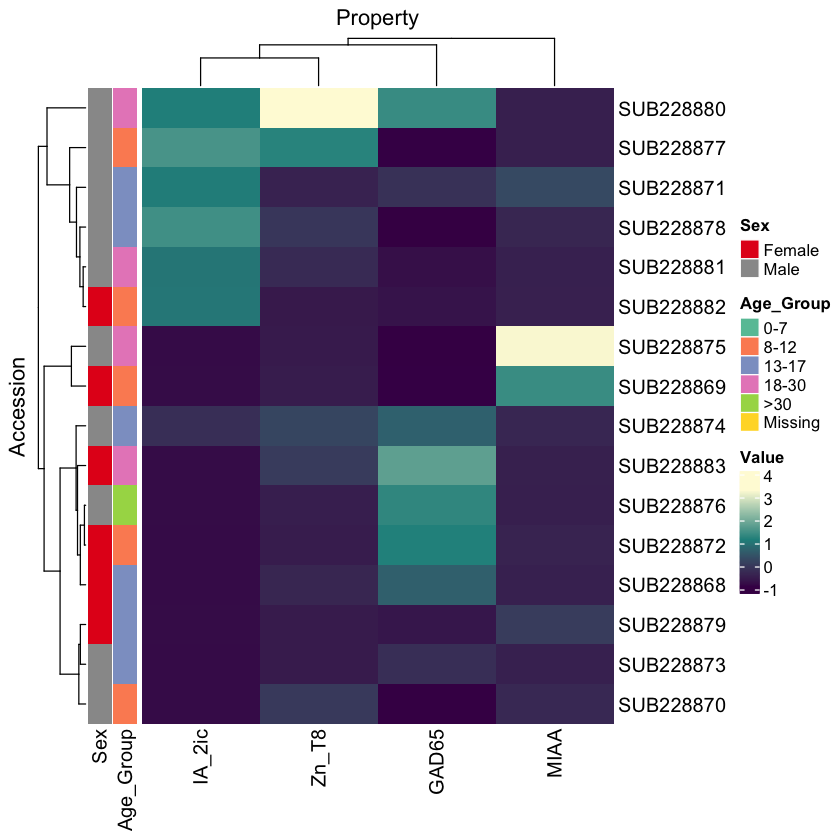

In [39]:
hm_1737_v1$hm_ward

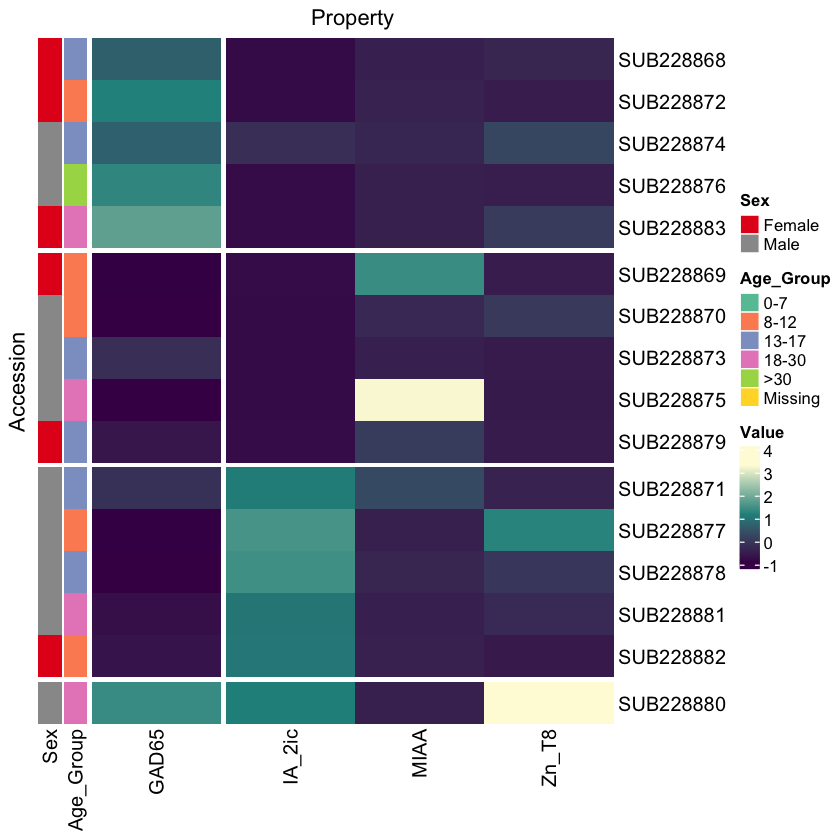

In [40]:
hm_1737_v1$hm_kmeans

**SDY524** - longitudinal data


In [41]:
getwd()

[1] "/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody"

In [42]:
sdy524_antibody <- as.matrix(read.csv("data/SDY524/SDY524_ITN-27AI.DataSet.Auto_Antibody.csv"))

In [43]:
sdy524_antibody.df <- data.frame(sdy524_antibody)

In [44]:
head(sdy524_antibody.df)

,ImmPort.Accession,Participant.ID,Treatment.Group,Intent.To.Treat.Population,Sequence.Num,Barcode,Visit_Num,Ship_Cond,Cond_Tube,AutoAB,Value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SUB146759,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,GAD65,418.000
2,SUB146759,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,IA_2ic,450.000
3,SUB146759,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,MIAA,0.015
4,SUB146759,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,ZNT8,0.180
5,SUB146759,AbATE_106306,hOKT3,Yes,334.0000,931676H01A,21,good,good,GAD65,616.000
6,SUB146759,AbATE_106306,hOKT3,Yes,334.0000,931676H01A,21,good,good,IA_2ic,288.000


In [45]:
sdy524_antibody.df %>%
      group_by(Treatment.Group) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Treatment.Group,count
<chr>,<int>
hOKT3,612
Controls,268


In [46]:
sdy524_antibody.df %>%
      group_by(Visit_Num) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Visit_Num,count
<chr>,<int>
-1,300
21,292
42,288


In [47]:
sdy524_subj <- as.matrix(read.csv("data/SDY524/SDY524_ITN027AI.DataSet.ADSTAND.csv",sep=","))

In [48]:
sdy524_subj.df <- data.frame(sdy524_subj)

In [49]:
colnames(sdy524_subj.df)

[1] "ImmPort.Accession"                   "Participant_ID"                     
 [3] "Age_Group"                           "Age_years"                          
 [5] "Completed_Study"                     "Completed_Study_Therapy"            
 [7] "Data_Snapshot_Date"                  "Diagnosis_Date"                     
 [9] "Study_Termination_Reason"            "Date_of_Study_Drug_Disctontinuation"
[11] "Discontinued_Therapy_Reason"         "Enrollment_Date"                    
[13] "Ethnicity"                           "First_Dose_Date"                    
[15] "Date_of_last_follow.up"              "Date_Completed_IS_Withdrawal"       
[17] "Intent_to_Treat"                     "Last_Dose_Date"                     
[19] "Time_off_IS.Drug_Days"               "Race"                               
[21] "Randomized"                          "Date_of_Randomization"              
[23] "Safety_Sample"                       "Group.Stratum"                      
[25] "Sex"                                 "Subject_Status"                     
[27] "Study_Identifier"                    "Date_of_Transplant"                 
[29] "Transplant_Group"                    "Randomized_Treatment_Group"

In [50]:
colnames(sdy524_antibody.df)

[1] "ImmPort.Accession"          "Participant.ID"            
 [3] "Treatment.Group"            "Intent.To.Treat.Population"
 [5] "Sequence.Num"               "Barcode"                   
 [7] "Visit_Num"                  "Ship_Cond"                 
 [9] "Cond_Tube"                  "AutoAB"                    
[11] "Value"

In [51]:
subject_df <- unique(sdy524_subj.df[,c ('ImmPort.Accession',
                                 'Participant_ID',
                                 'Age_Group',
                                 'Age_years',
                                 'Race',
                                 'Sex',
                                 'Ethnicity')])

In [52]:
sdy524_df <- left_join(subject_df, sdy524_antibody.df, by = "ImmPort.Accession")

In [53]:
any(duplicated(names(sdy524_df)))
names(sdy524_df)[duplicated(names(sdy524_df))]

[1] FALSE

character(0)

In [54]:
dim(sdy524_df)

[1] 888  17

In [55]:
head(sdy524_df)

,ImmPort.Accession,Participant_ID,Age_Group,Age_years,Race,Sex,Ethnicity,Participant.ID,Treatment.Group,Intent.To.Treat.Population,Sequence.Num,Barcode,Visit_Num,Ship_Cond,Cond_Tube,AutoAB,Value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,GAD65,418.000
2,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,IA_2ic,450.000
3,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,MIAA,0.015
4,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,312.0000,921897H16A,-1,good,good,ZNT8,0.180
5,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,334.0000,931676H01A,21,good,good,GAD65,616.000
6,SUB146759,AbATE_106306,8-12,13.0,American Indian or Alaska Native; White,Female,Not Hispanic or Latino,AbATE_106306,hOKT3,Yes,334.0000,931676H01A,21,good,good,IA_2ic,288.000


In [56]:
sdy524_df %>%
      group_by(Age_Group) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Age_Group,count
<chr>,<int>
8-12,558
13-17,269
18-30,61


In [57]:
sdy524_df %>%
      group_by(Visit_Num) %>%
      summarise(count = n()) %>%
      arrange(desc(count))

Visit_Num,count
<chr>,<int>
-1,300
21,292
42,288
NA,8


In [58]:
## baseline (-1)
tidy_524_v_m1 <- aa_prepare(
  sdy524_df,
  accession_col     = "ImmPort.Accession",
  sex_col           = "Sex",
  age_group_col     = "Age_Group",
  age_years_col     = "Age_years",
  analyte_name_col  = "AutoAB",
  analyte_value_col = "Value",
  visit_cols        = c("Visit_Num","Visitnum","Visit"),
  restrict_visits   = -1
)
hm_524_v_m1 <- aa_heatmaps(tidy_524_v_m1, scale_mode = "column", k_rows = 4, k_cols = 2)

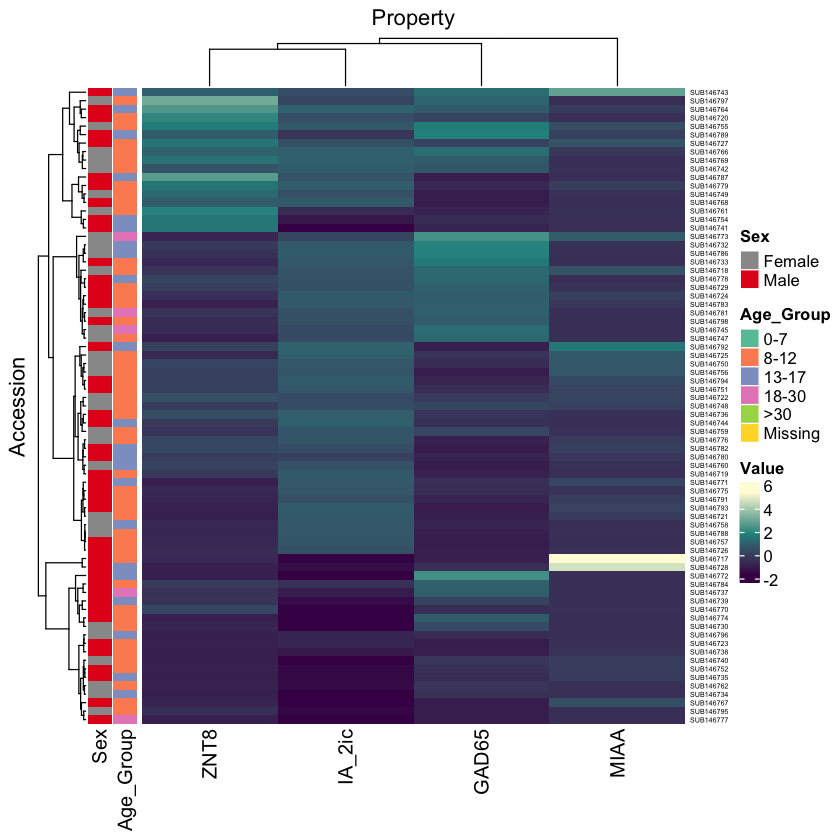

In [61]:
hm_524_v_m1$hm_ward

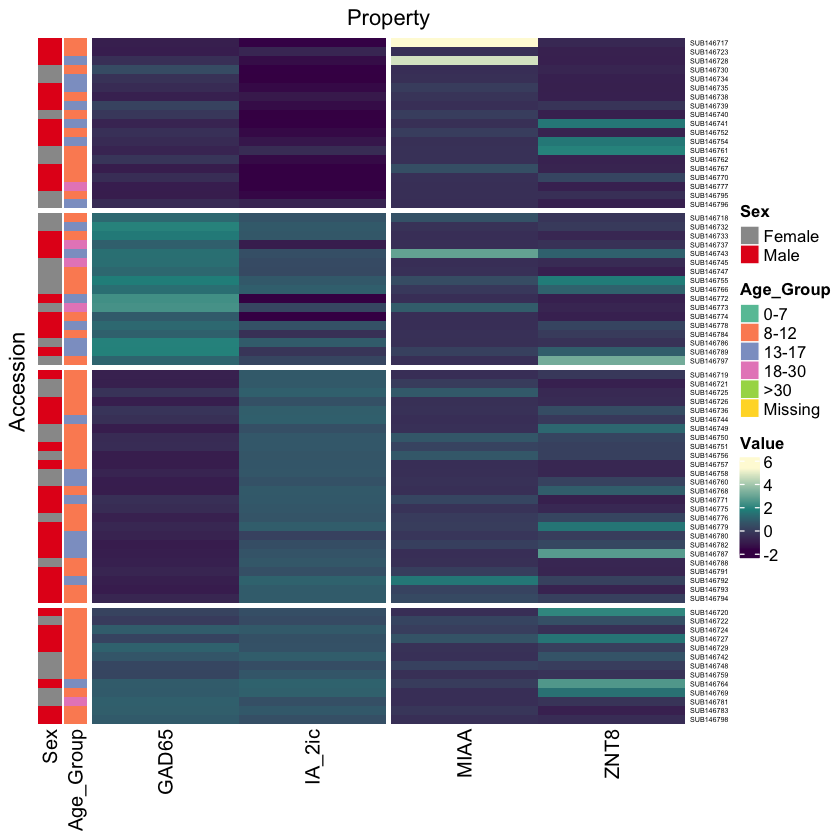

In [62]:
hm_524_v_m1$hm_kmeans

In [63]:
## day 21
tidy_524_v21 <- aa_prepare(
  sdy524_df,
  accession_col     = "ImmPort.Accession",
  sex_col           = "Sex",
  age_group_col     = "Age_Group",
  age_years_col     = "Age_years",
  analyte_name_col  = "AutoAB",
  analyte_value_col = "Value",
  visit_cols        = c("Visit_Num","Visitnum","Visit"),
  restrict_visits   = 21
)
hm_524_v21 <- aa_heatmaps(tidy_524_v21, scale_mode = "column", k_rows = 4, k_cols = 2)

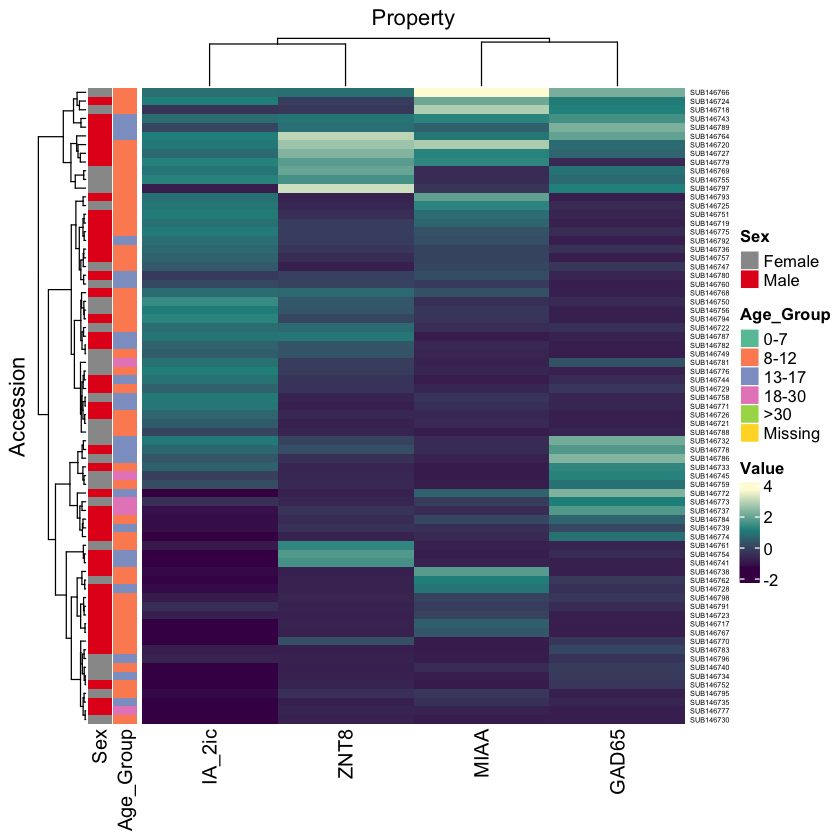

In [64]:
hm_524_v21$hm_ward

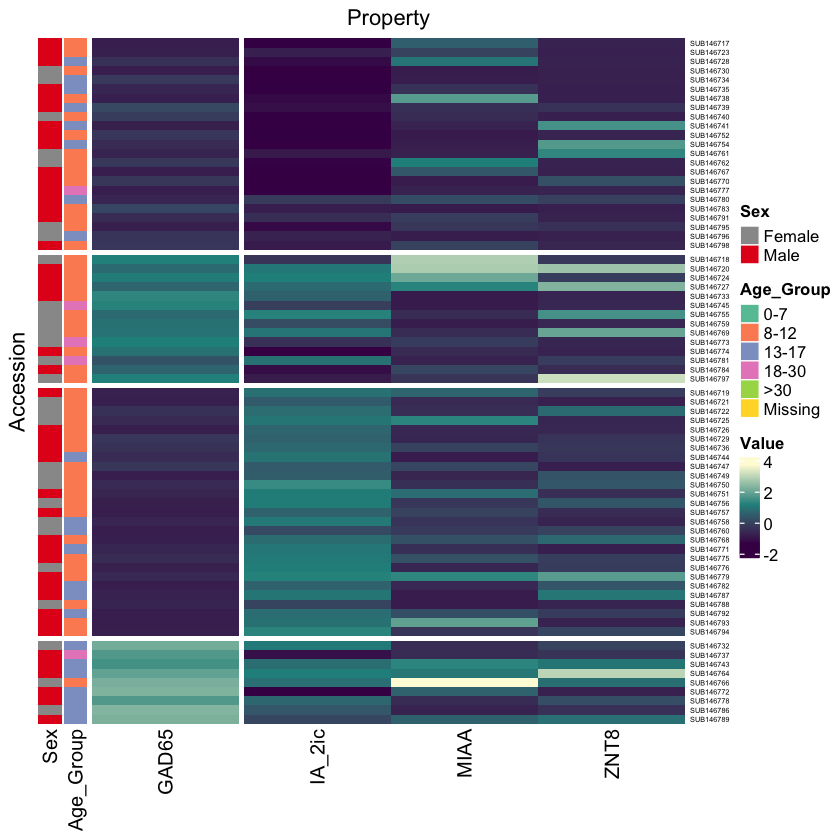

In [65]:
hm_524_v21$hm_kmeans

In [66]:
## day 42
tidy_524_v42 <- aa_prepare(
  sdy524_df,
  accession_col     = "ImmPort.Accession",
  sex_col           = "Sex",
  age_group_col     = "Age_Group",
  age_years_col     = "Age_years",
  analyte_name_col  = "AutoAB",
  analyte_value_col = "Value",
  visit_cols        = c("Visit_Num","Visitnum","Visit"),
  restrict_visits   = 42
)
hm_524_v42 <- aa_heatmaps(tidy_524_v42, scale_mode = "column", k_rows = 4, k_cols = 2)


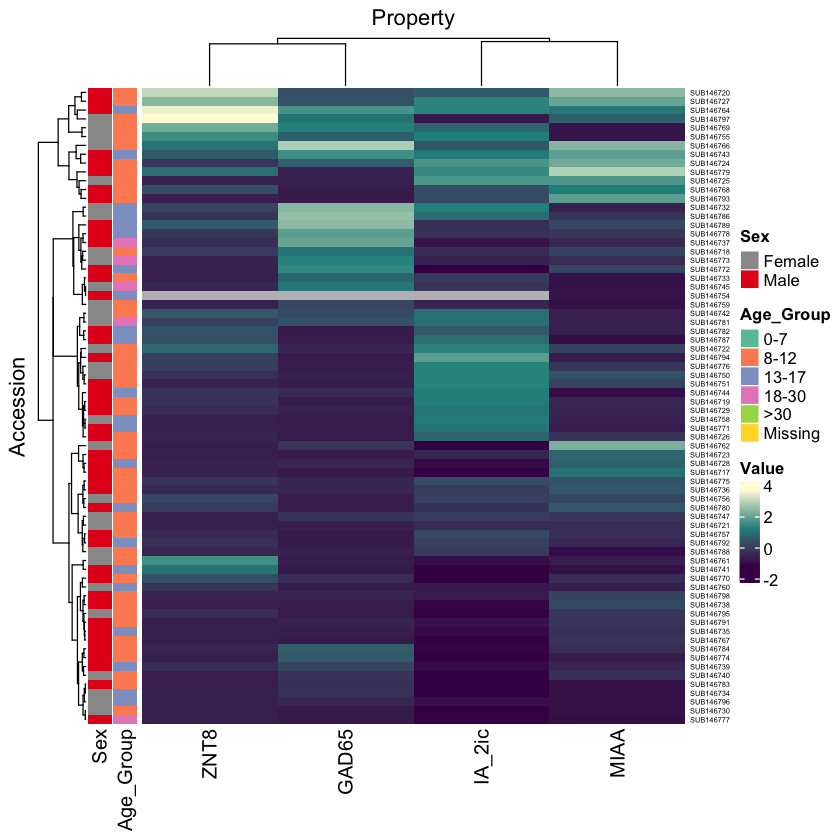

In [67]:
hm_524_v42$hm_ward

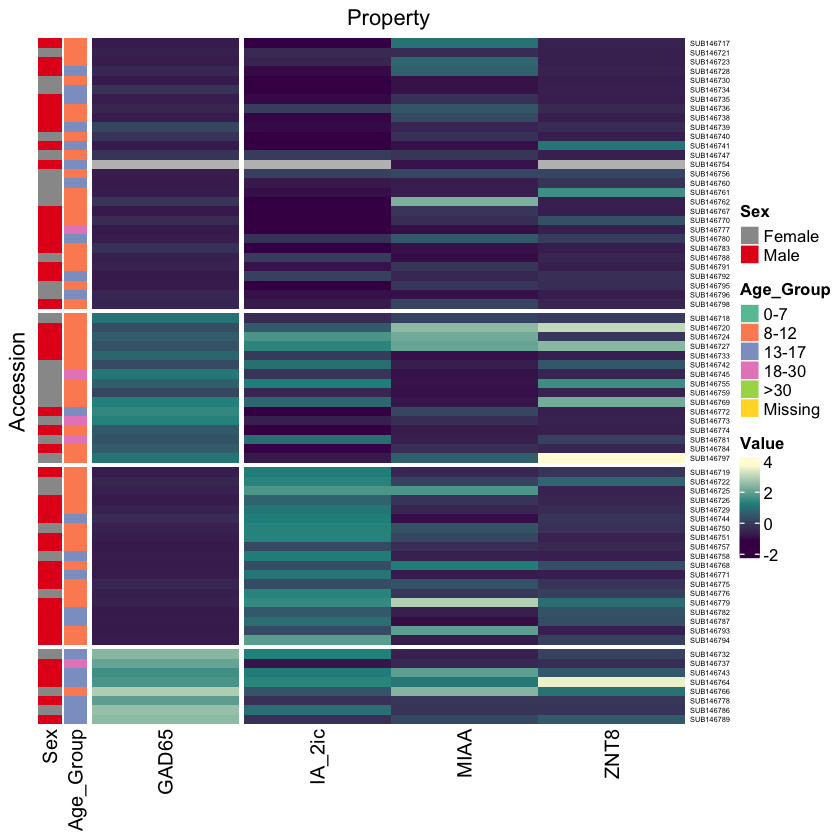

In [68]:
hm_524_v42$hm_kmeans